# Image to Image Translation using Pix2Pix

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import cv2
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model

In [2]:
import Automold as am
import Helpers as hp

In [3]:
devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0] ,enable=True)

In [4]:
BATCH_SIZE = 1
IMAGE_SIZE = 256

In [5]:
data_path = r"images\10k\train"  # Replace with your dataset path
images = []

for img_name in tqdm(os.listdir(data_path)):
    img_path = os.path.join(data_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print(f"Loaded {len(images)} images.")

100%|██████████| 1000/1000 [00:04<00:00, 230.56it/s]

Loaded 1000 images.


In [6]:
test_data_path = r"images\10k\test"  # Replace with your dataset path
test_images = []

for img_name in tqdm(os.listdir(test_data_path)):
    img_path = os.path.join(test_data_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        test_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print(f"Loaded {len(test_images)} images.")

100%|██████████| 500/500 [00:02<00:00, 246.84it/s]

Loaded 500 images.


In [7]:
# Cell 4: Augment Images (Rain, Snow, Brightness)
augmented_images = []
labels = []

for img in tqdm(images):
    augmented_images.append(am.add_rain(img))
    labels.append(img)  # Clean image for comparison
    augmented_images.append(am.add_snow(img))
    labels.append(img)


augmented_images = np.array([cv2.resize(img, (256, 256)) for img in augmented_images])
labels = np.array([cv2.resize(img, (256, 256)) for img in labels])


print(f"Augmented dataset size: {len(augmented_images)}")


100%|██████████| 1000/1000 [00:32<00:00, 30.73it/s]


Augmented dataset size: 2000


In [8]:
# Cell 4: Augment Images (Rain, Snow, Brightness)
test_augmented_images = []
test_labels = []

for img in tqdm(test_images):
    test_augmented_images.append(am.add_rain(img))
    test_labels.append(img)  # Clean image for comparison
    test_augmented_images.append(am.add_snow(img))
    test_labels.append(img)


test_augmented_images = np.array([cv2.resize(img, (256, 256)) for img in test_augmented_images])
test_labels = np.array([cv2.resize(img, (256, 256)) for img in test_labels])


print(f"Augmented dataset size: {len(test_augmented_images)}")


100%|██████████| 500/500 [00:16<00:00, 31.00it/s]


Augmented dataset size: 1000


In [9]:
import tensorflow as tf
import numpy as np

# Assuming augmented_images and labels are NumPy arrays of shape (N, 256, 256, 3)
# where N is the number of samples

# Normalize images to range [0, 1] (if not already normalized)
augmented_images = augmented_images.astype(np.float32) / 255.0
labels = labels.astype(np.float32) / 255.0

# Create a TensorFlow Dataset from the augmented images and labels
train_dataset = tf.data.Dataset.from_tensor_slices((augmented_images, labels))

# Define a mapping function to preprocess data if needed

def preprocess_images(input_image, label_image):
    # Resize to (256, 256)
    # input_image = tf.image.resize(input_image, (256, 256))
    # label_image = tf.image.resize(label_image, (256, 256))
    return input_image, label_image



# Apply the preprocessing function to the dataset
train_dataset = train_dataset.map(preprocess_images)

# Shuffle and batch the dataset
BATCH_SIZE = 1  # Adjust batch size as needed
train_dataset = train_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)

# Inspect the dataset
for batch in train_dataset.take(1):
    print("Input batch shape:", batch[0].shape)
    print("Label batch shape:", batch[1].shape)



Input batch shape: (1, 256, 256, 3)
Label batch shape: (1, 256, 256, 3)


In [10]:
import tensorflow as tf
import numpy as np

# Assuming augmented_images and labels are NumPy arrays of shape (N, 256, 256, 3)
# where N is the number of samples

# Normalize images to range [0, 1] (if not already normalized)
test_augmented_images = test_augmented_images.astype(np.float32) / 255.0
test_labels = test_labels.astype(np.float32) / 255.0

# Create a TensorFlow Dataset from the augmented images and labels
test_dataset = tf.data.Dataset.from_tensor_slices((test_augmented_images, test_labels))

# Define a mapping function to preprocess data if needed

def preprocess_images(input_image, label_image):
    # Resize to (256, 256)
    # input_image = tf.image.resize(input_image, (256, 256))
    # label_image = tf.image.resize(label_image, (256, 256))
    return input_image, label_image



# Apply the preprocessing function to the dataset
test_dataset = test_dataset.map(preprocess_images)

# Shuffle and batch the dataset
BATCH_SIZE = 1  # Adjust batch size as needed
test_dataset = test_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)

# Inspect the dataset
for batch in test_dataset.take(1):
    print("Input batch shape:", batch[0].shape)
    print("Label batch shape:", batch[1].shape)



Input batch shape: (1, 256, 256, 3)
Label batch shape: (1, 256, 256, 3)


In [11]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [12]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [13]:
# downsample block
def downsample(filters, size, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())
        
    result.add(LeakyReLU())
    return result
down_model = downsample(3,4)
# down_result = down_model(tf.expand_dims(x, axis = 0))
# print(down_result.shape)

In [14]:
# upsample block
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result
up_model = upsample(3,4)
# up_result = up_model(down_result)
# print(up_result.shape)

In [15]:
def generator():
    inputs = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3])
    down_stack = [
        downsample(64, 4, batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]
    
    
    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(512, 4, dropout=True),
        upsample(512, 4),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    
    x = last(x)
    return Model(inputs = inputs, outputs = x)

In [16]:
gen = generator()
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_3 (Sequential)      (None, 64, 64, 128)  131584      ['sequential_2[0][0]']           
                                                                                              

In [17]:
# plot_model(gen, show_shapes=True, dpi = 64)

In [18]:
LAMBDA = 100

In [19]:
from keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [20]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [21]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    
    inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3], name = "input_image")
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3], name = "target_image")
    x = Concatenate()([inp, tar])
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

In [22]:
disc = discriminator()
disc.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

In [23]:
# plot_model(disc, show_shapes=True, dpi = 64)

In [24]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [25]:
generator_optimizer = Adam(lr= 2e-4, beta_1=0.5)
discriminator_optimizer = Adam(lr = 2e-4, beta_1=0.5)

c:\Users\fazil\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [38]:
def save_images(model, test_input, target, epoch):
    prediction = model(test_input, training= True)
    plt.figure(figsize = (2.56,2.56))
    display_list= [prediction[0]]
    # title = ["Predicton Image"]
    for i in range(1):
        # plt.subplot(1, 1, i+1)
        # plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    plt.savefig(f"output/epoch_{epoch}.jpg")
    plt.close()

In [27]:
# make sure output directory exists to save images
if os.path.exists(r".output"):
    os.mkdir("output")

In [28]:
epochs = 200

In [29]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training = True)
        
        disc_real_output = disc([input_image, target], training = True)
        disc_generated_output = disc([input_image, gen_output], training = True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
        return gen_total_loss, disc_loss

In [30]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        for input_, target in test_ds.take(1):
            save_images(gen, input_, target, epoch)
        # Train
        print(f"Epoch {epoch}")
        for n, (input_, target) in train_ds.enumerate():
            gen_loss, disc_loss = train_step(input_, target, epoch)
        print("Generator loss {:.2f} Discriminator loss {:.2f}".format(gen_loss, disc_loss))
        print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))
        

In [31]:
import keras
keras.backend.clear_session()

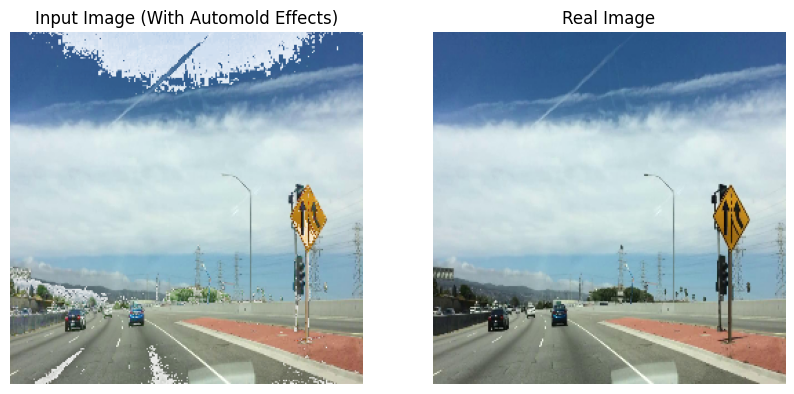

In [32]:
import matplotlib.pyplot as plt

# Function to display images
def display_images(dataset, num_images=5):
    for batch in dataset.take(1):  # Take one batch of data
        input_images, real_images = batch  # Unpack the batch
        for i in range(min(num_images, input_images.shape[0])):  # Show up to `num_images`
            plt.figure(figsize=(10, 5))
            
            # Display the input image
            plt.subplot(1, 2, 1)
            plt.imshow(input_images[i].numpy().astype("float32"))
            plt.title("Input Image (With Automold Effects)")
            plt.axis("off")
            
            # Display the real image
            plt.subplot(1, 2, 2)
            plt.imshow(real_images[i].numpy().astype("float32"))
            plt.title("Real Image")
            plt.axis("off")
            
            plt.show()

# Display a few images from the dataset
display_images(train_dataset, num_images=5)


In [39]:
fit(train_dataset, epochs, test_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0
Generator loss 12.90 Discriminator loss 0.12
Time take for epoch 1 is 108.8971483707428 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1
Generator loss 13.66 Discriminator loss 1.49
Time take for epoch 2 is 109.90636205673218 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2
Generator loss 13.40 Discriminator loss 0.13
Time take for epoch 3 is 107.55968403816223 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3
Generator loss 13.59 Discriminator loss 1.16
Time take for epoch 4 is 107.81972670555115 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4
Generator loss 11.19 Discriminator loss 0.36
Time take for epoch 5 is 107.68403840065002 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5
Generator loss 17.80 Discriminator loss 1.10
Time take for epoch 6 is 109.16715669631958 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6
Generator loss 9.67 Discriminator loss 0.49
Time take for epoch 7 is 108.2791051864624 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7
Generator loss 6.54 Discriminator loss 1.10
Time take for epoch 8 is 108.2417356967926 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8
Generator loss 15.90 Discriminator loss 0.22
Time take for epoch 9 is 108.35229206085205 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9
Generator loss 8.23 Discriminator loss 0.21
Time take for epoch 10 is 109.64031529426575 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 10
Generator loss 4.29 Discriminator loss 2.33
Time take for epoch 11 is 108.54570436477661 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 11
Generator loss 13.41 Discriminator loss 0.08
Time take for epoch 12 is 108.246267080307 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 12
Generator loss 7.33 Discriminator loss 0.08
Time take for epoch 13 is 108.26969408988953 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 13
Generator loss 11.06 Discriminator loss 0.08
Time take for epoch 14 is 108.25974917411804 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 14
Generator loss 6.39 Discriminator loss 0.48
Time take for epoch 15 is 108.06849932670593 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 15
Generator loss 8.30 Discriminator loss 0.16
Time take for epoch 16 is 108.00410747528076 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 16
Generator loss 12.52 Discriminator loss 0.07
Time take for epoch 17 is 108.15645051002502 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 17
Generator loss 5.60 Discriminator loss 0.59
Time take for epoch 18 is 108.80699133872986 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 18
Generator loss 10.12 Discriminator loss 0.14
Time take for epoch 19 is 108.34198117256165 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 19
Generator loss 9.26 Discriminator loss 0.35
Time take for epoch 20 is 108.29749131202698 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20
Generator loss 6.08 Discriminator loss 0.44
Time take for epoch 21 is 108.27854990959167 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 21
Generator loss 5.78 Discriminator loss 0.48
Time take for epoch 22 is 108.31539011001587 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 22
Generator loss 4.67 Discriminator loss 1.48
Time take for epoch 23 is 108.32267737388611 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 23
Generator loss 10.42 Discriminator loss 0.08
Time take for epoch 24 is 108.23085951805115 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 24
Generator loss 11.09 Discriminator loss 0.26
Time take for epoch 25 is 108.1301474571228 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 25
Generator loss 6.02 Discriminator loss 0.31
Time take for epoch 26 is 108.2158682346344 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 26
Generator loss 7.71 Discriminator loss 0.28
Time take for epoch 27 is 108.31517887115479 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 27
Generator loss 6.72 Discriminator loss 0.56
Time take for epoch 28 is 108.25269484519958 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 28
Generator loss 6.28 Discriminator loss 0.63
Time take for epoch 29 is 108.5772967338562 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 29
Generator loss 4.38 Discriminator loss 0.90
Time take for epoch 30 is 108.35800170898438 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 30
Generator loss 5.51 Discriminator loss 0.67
Time take for epoch 31 is 108.36681270599365 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 31
Generator loss 4.25 Discriminator loss 0.70
Time take for epoch 32 is 108.3465576171875 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 32
Generator loss 11.86 Discriminator loss 0.05
Time take for epoch 33 is 108.35390257835388 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 33
Generator loss 12.16 Discriminator loss 0.19
Time take for epoch 34 is 108.40987658500671 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 34
Generator loss 4.80 Discriminator loss 0.52
Time take for epoch 35 is 108.33550310134888 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 35
Generator loss 6.05 Discriminator loss 1.73
Time take for epoch 36 is 108.34764981269836 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 36
Generator loss 6.38 Discriminator loss 0.53
Time take for epoch 37 is 108.30228996276855 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 37
Generator loss 6.01 Discriminator loss 0.46
Time take for epoch 38 is 108.12000918388367 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 38
Generator loss 8.00 Discriminator loss 0.21
Time take for epoch 39 is 108.16087079048157 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 39
Generator loss 6.28 Discriminator loss 0.43
Time take for epoch 40 is 107.94542217254639 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40
Generator loss 8.02 Discriminator loss 0.12
Time take for epoch 41 is 108.08568835258484 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 41
Generator loss 6.09 Discriminator loss 1.16
Time take for epoch 42 is 107.51908206939697 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 42
Generator loss 12.10 Discriminator loss 0.24
Time take for epoch 43 is 107.60213232040405 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 43
Generator loss 9.28 Discriminator loss 0.17
Time take for epoch 44 is 107.576251745224 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 44
Generator loss 4.85 Discriminator loss 0.98
Time take for epoch 45 is 107.66603827476501 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 45
Generator loss 4.21 Discriminator loss 1.26
Time take for epoch 46 is 107.59534454345703 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 46
Generator loss 5.09 Discriminator loss 0.78
Time take for epoch 47 is 107.8983895778656 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 47
Generator loss 10.83 Discriminator loss 1.29
Time take for epoch 48 is 107.85800862312317 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 48
Generator loss 6.49 Discriminator loss 0.98
Time take for epoch 49 is 107.7610387802124 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 49
Generator loss 6.64 Discriminator loss 0.31
Time take for epoch 50 is 107.82965230941772 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 50
Generator loss 8.03 Discriminator loss 0.54
Time take for epoch 51 is 107.87365102767944 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 51
Generator loss 10.60 Discriminator loss 0.11
Time take for epoch 52 is 107.85940027236938 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 52
Generator loss 5.51 Discriminator loss 0.97
Time take for epoch 53 is 107.86274480819702 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 53
Generator loss 4.76 Discriminator loss 0.75
Time take for epoch 54 is 107.77515149116516 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 54
Generator loss 7.45 Discriminator loss 0.15
Time take for epoch 55 is 107.64003324508667 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 55
Generator loss 5.55 Discriminator loss 0.67
Time take for epoch 56 is 107.7065646648407 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 56
Generator loss 5.74 Discriminator loss 0.56
Time take for epoch 57 is 108.46162128448486 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 57
Generator loss 4.66 Discriminator loss 1.78
Time take for epoch 58 is 107.64327669143677 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 58
Generator loss 4.73 Discriminator loss 0.71
Time take for epoch 59 is 107.62393474578857 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 59
Generator loss 4.97 Discriminator loss 0.55
Time take for epoch 60 is 107.53169965744019 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60
Generator loss 5.50 Discriminator loss 0.81
Time take for epoch 61 is 107.57717776298523 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 61
Generator loss 6.12 Discriminator loss 0.63
Time take for epoch 62 is 107.5058822631836 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 62
Generator loss 6.00 Discriminator loss 0.21
Time take for epoch 63 is 107.59522604942322 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 63
Generator loss 4.19 Discriminator loss 1.44
Time take for epoch 64 is 107.4835798740387 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 64
Generator loss 5.55 Discriminator loss 0.85
Time take for epoch 65 is 107.43254709243774 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 65
Generator loss 3.81 Discriminator loss 1.11
Time take for epoch 66 is 107.470778465271 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 66
Generator loss 6.62 Discriminator loss 1.03
Time take for epoch 67 is 107.59808349609375 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 67
Generator loss 9.55 Discriminator loss 0.16
Time take for epoch 68 is 107.36772632598877 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 68
Generator loss 5.64 Discriminator loss 1.07
Time take for epoch 69 is 107.70416498184204 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 69
Generator loss 4.97 Discriminator loss 0.82
Time take for epoch 70 is 107.40480399131775 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 70
Generator loss 4.25 Discriminator loss 0.87
Time take for epoch 71 is 107.55050039291382 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 71
Generator loss 9.54 Discriminator loss 0.06
Time take for epoch 72 is 107.69565939903259 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 72
Generator loss 11.21 Discriminator loss 0.03
Time take for epoch 73 is 107.62216711044312 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 73
Generator loss 5.36 Discriminator loss 0.64
Time take for epoch 74 is 107.41633200645447 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 74
Generator loss 5.00 Discriminator loss 0.56
Time take for epoch 75 is 107.60568571090698 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 75
Generator loss 4.27 Discriminator loss 1.03
Time take for epoch 76 is 108.06035327911377 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 76
Generator loss 5.80 Discriminator loss 0.59
Time take for epoch 77 is 107.69885635375977 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 77
Generator loss 10.19 Discriminator loss 0.02
Time take for epoch 78 is 107.6038613319397 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 78
Generator loss 7.35 Discriminator loss 0.26
Time take for epoch 79 is 107.57607364654541 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 79
Generator loss 5.74 Discriminator loss 0.34
Time take for epoch 80 is 107.5229811668396 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80
Generator loss 6.21 Discriminator loss 0.50
Time take for epoch 81 is 107.62067246437073 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 81
Generator loss 9.39 Discriminator loss 0.47
Time take for epoch 82 is 107.48468923568726 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 82
Generator loss 11.03 Discriminator loss 0.03
Time take for epoch 83 is 107.41931295394897 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 83
Generator loss 4.23 Discriminator loss 1.53
Time take for epoch 84 is 107.73272681236267 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 84
Generator loss 4.38 Discriminator loss 0.88
Time take for epoch 85 is 107.61026954650879 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 85
Generator loss 4.42 Discriminator loss 0.69
Time take for epoch 86 is 107.85271263122559 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 86
Generator loss 9.77 Discriminator loss 0.09
Time take for epoch 87 is 107.4668698310852 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 87
Generator loss 5.40 Discriminator loss 1.01
Time take for epoch 88 is 107.5229914188385 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 88
Generator loss 5.98 Discriminator loss 0.80
Time take for epoch 89 is 107.63177394866943 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 89
Generator loss 11.47 Discriminator loss 0.02
Time take for epoch 90 is 107.45232677459717 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 90
Generator loss 4.01 Discriminator loss 1.32
Time take for epoch 91 is 107.5224461555481 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 91
Generator loss 6.66 Discriminator loss 0.43
Time take for epoch 92 is 107.6557126045227 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 92
Generator loss 4.82 Discriminator loss 0.77
Time take for epoch 93 is 107.49794697761536 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 93
Generator loss 7.66 Discriminator loss 0.69
Time take for epoch 94 is 107.71961331367493 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 94
Generator loss 4.88 Discriminator loss 0.77
Time take for epoch 95 is 107.57085418701172 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 95
Generator loss 8.91 Discriminator loss 0.16
Time take for epoch 96 is 107.81079149246216 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 96
Generator loss 7.47 Discriminator loss 0.18
Time take for epoch 97 is 107.39609146118164 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 97
Generator loss 5.55 Discriminator loss 1.01
Time take for epoch 98 is 107.6214919090271 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 98
Generator loss 5.86 Discriminator loss 1.27
Time take for epoch 99 is 107.38533902168274 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 99
Generator loss 5.63 Discriminator loss 0.79
Time take for epoch 100 is 108.36044144630432 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100
Generator loss 7.31 Discriminator loss 0.15
Time take for epoch 101 is 107.64985275268555 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 101
Generator loss 10.79 Discriminator loss 0.12
Time take for epoch 102 is 107.50841021537781 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 102
Generator loss 3.68 Discriminator loss 1.16
Time take for epoch 103 is 107.71856570243835 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 103
Generator loss 7.50 Discriminator loss 0.80
Time take for epoch 104 is 107.45697402954102 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 104
Generator loss 5.57 Discriminator loss 0.85
Time take for epoch 105 is 107.67159843444824 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 105
Generator loss 7.69 Discriminator loss 0.25
Time take for epoch 106 is 107.6123275756836 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 106
Generator loss 5.98 Discriminator loss 0.58
Time take for epoch 107 is 107.4992504119873 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 107
Generator loss 4.26 Discriminator loss 1.66
Time take for epoch 108 is 107.61266493797302 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 108
Generator loss 5.78 Discriminator loss 0.68
Time take for epoch 109 is 107.6289234161377 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 109
Generator loss 3.33 Discriminator loss 1.09
Time take for epoch 110 is 107.5348732471466 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 110
Generator loss 5.23 Discriminator loss 0.46
Time take for epoch 111 is 107.89954900741577 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 111
Generator loss 3.48 Discriminator loss 1.18
Time take for epoch 112 is 107.73928642272949 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 112
Generator loss 6.05 Discriminator loss 1.59
Time take for epoch 113 is 107.89151644706726 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 113
Generator loss 3.47 Discriminator loss 1.76
Time take for epoch 114 is 107.74461531639099 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 114
Generator loss 9.70 Discriminator loss 0.07
Time take for epoch 115 is 107.53558468818665 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 115
Generator loss 4.41 Discriminator loss 1.96
Time take for epoch 116 is 107.60795783996582 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 116
Generator loss 4.66 Discriminator loss 1.01
Time take for epoch 117 is 107.7174243927002 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 117
Generator loss 6.07 Discriminator loss 1.26
Time take for epoch 118 is 107.70011806488037 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 118
Generator loss 5.50 Discriminator loss 0.86
Time take for epoch 119 is 107.6186888217926 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 119
Generator loss 6.30 Discriminator loss 1.50
Time take for epoch 120 is 107.6285297870636 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 120
Generator loss 7.69 Discriminator loss 0.16
Time take for epoch 121 is 107.6664547920227 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 121
Generator loss 7.06 Discriminator loss 1.44
Time take for epoch 122 is 107.39836192131042 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 122
Generator loss 8.02 Discriminator loss 0.18
Time take for epoch 123 is 107.52727317810059 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 123
Generator loss 4.29 Discriminator loss 0.89
Time take for epoch 124 is 107.73973035812378 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 124
Generator loss 10.12 Discriminator loss 0.39
Time take for epoch 125 is 107.75666165351868 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 125
Generator loss 3.43 Discriminator loss 1.09
Time take for epoch 126 is 107.7883608341217 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 126
Generator loss 6.11 Discriminator loss 0.52
Time take for epoch 127 is 107.49150729179382 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 127
Generator loss 4.17 Discriminator loss 0.98
Time take for epoch 128 is 107.57817268371582 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 128
Generator loss 9.75 Discriminator loss 0.35
Time take for epoch 129 is 108.41040515899658 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 129
Generator loss 5.10 Discriminator loss 0.70
Time take for epoch 130 is 107.73987245559692 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 130
Generator loss 4.49 Discriminator loss 0.48
Time take for epoch 131 is 107.7024712562561 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 131
Generator loss 7.00 Discriminator loss 0.22
Time take for epoch 132 is 107.58543229103088 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 132
Generator loss 7.77 Discriminator loss 0.32
Time take for epoch 133 is 107.81293296813965 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 133
Generator loss 11.24 Discriminator loss 2.30
Time take for epoch 134 is 107.54372954368591 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 134
Generator loss 4.72 Discriminator loss 0.97
Time take for epoch 135 is 107.79843950271606 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 135
Generator loss 3.92 Discriminator loss 0.83
Time take for epoch 136 is 107.58677554130554 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 136
Generator loss 5.39 Discriminator loss 1.03
Time take for epoch 137 is 107.89057540893555 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 137
Generator loss 4.01 Discriminator loss 2.03
Time take for epoch 138 is 108.01109552383423 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 138
Generator loss 6.62 Discriminator loss 0.52
Time take for epoch 139 is 107.78877806663513 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 139
Generator loss 3.67 Discriminator loss 1.39
Time take for epoch 140 is 107.78831458091736 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 140
Generator loss 7.63 Discriminator loss 0.98
Time take for epoch 141 is 107.5641815662384 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 141
Generator loss 7.57 Discriminator loss 0.14
Time take for epoch 142 is 107.74721240997314 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 142
Generator loss 8.74 Discriminator loss 0.81
Time take for epoch 143 is 107.55557489395142 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 143
Generator loss 8.13 Discriminator loss 0.05
Time take for epoch 144 is 107.56517934799194 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 144
Generator loss 7.04 Discriminator loss 1.60
Time take for epoch 145 is 107.55945587158203 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 145
Generator loss 4.16 Discriminator loss 1.36
Time take for epoch 146 is 107.70246171951294 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 146
Generator loss 4.22 Discriminator loss 1.08
Time take for epoch 147 is 107.60040879249573 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 147
Generator loss 6.14 Discriminator loss 0.39
Time take for epoch 148 is 107.6889317035675 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 148
Generator loss 7.82 Discriminator loss 0.28
Time take for epoch 149 is 107.56115078926086 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 149
Generator loss 4.84 Discriminator loss 0.25
Time take for epoch 150 is 107.56138873100281 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 150
Generator loss 7.43 Discriminator loss 1.48
Time take for epoch 151 is 107.47042489051819 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 151
Generator loss 4.66 Discriminator loss 0.56
Time take for epoch 152 is 107.67280960083008 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 152
Generator loss 2.67 Discriminator loss 1.97
Time take for epoch 153 is 107.57271599769592 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 153
Generator loss 8.18 Discriminator loss 0.13
Time take for epoch 154 is 107.5665647983551 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 154
Generator loss 6.72 Discriminator loss 0.11
Time take for epoch 155 is 107.39470100402832 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 155
Generator loss 4.51 Discriminator loss 0.92
Time take for epoch 156 is 107.57571816444397 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 156
Generator loss 5.50 Discriminator loss 0.22
Time take for epoch 157 is 107.60949182510376 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 157
Generator loss 9.38 Discriminator loss 2.17
Time take for epoch 158 is 107.59081435203552 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 158
Generator loss 5.17 Discriminator loss 0.30
Time take for epoch 159 is 107.63757729530334 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 159
Generator loss 7.89 Discriminator loss 0.21
Time take for epoch 160 is 107.496994972229 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 160
Generator loss 3.73 Discriminator loss 0.86
Time take for epoch 161 is 107.68853282928467 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 161
Generator loss 8.14 Discriminator loss 0.06
Time take for epoch 162 is 107.56734609603882 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 162
Generator loss 4.52 Discriminator loss 1.23
Time take for epoch 163 is 107.61734247207642 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 163
Generator loss 5.37 Discriminator loss 0.89
Time take for epoch 164 is 108.84821796417236 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 164
Generator loss 3.92 Discriminator loss 1.28
Time take for epoch 165 is 107.72311854362488 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 165
Generator loss 4.08 Discriminator loss 1.38
Time take for epoch 166 is 107.54232335090637 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 166
Generator loss 7.25 Discriminator loss 0.25
Time take for epoch 167 is 107.58298540115356 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 167
Generator loss 4.58 Discriminator loss 1.02
Time take for epoch 168 is 107.51855731010437 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 168
Generator loss 6.03 Discriminator loss 2.27
Time take for epoch 169 is 107.5397253036499 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 169
Generator loss 6.43 Discriminator loss 0.12
Time take for epoch 170 is 107.51281094551086 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 170
Generator loss 5.00 Discriminator loss 1.42
Time take for epoch 171 is 107.5309727191925 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 171
Generator loss 9.55 Discriminator loss 0.08
Time take for epoch 172 is 107.38688135147095 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 172
Generator loss 5.73 Discriminator loss 0.72
Time take for epoch 173 is 107.55318593978882 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 173
Generator loss 6.18 Discriminator loss 1.07
Time take for epoch 174 is 107.35450267791748 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 174
Generator loss 4.80 Discriminator loss 1.04
Time take for epoch 175 is 107.4111557006836 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 175
Generator loss 4.75 Discriminator loss 1.05
Time take for epoch 176 is 107.55008816719055 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 176
Generator loss 6.33 Discriminator loss 0.51
Time take for epoch 177 is 107.5368902683258 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 177
Generator loss 4.22 Discriminator loss 1.73
Time take for epoch 178 is 107.37256193161011 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 178
Generator loss 6.57 Discriminator loss 0.61
Time take for epoch 179 is 107.63663411140442 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 179
Generator loss 4.96 Discriminator loss 0.56
Time take for epoch 180 is 107.549156665802 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 180
Generator loss 3.56 Discriminator loss 3.85
Time take for epoch 181 is 107.565021276474 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 181
Generator loss 4.00 Discriminator loss 1.44
Time take for epoch 182 is 107.57541584968567 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 182
Generator loss 7.10 Discriminator loss 0.66
Time take for epoch 183 is 107.55076241493225 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 183
Generator loss 3.68 Discriminator loss 1.08
Time take for epoch 184 is 107.61081314086914 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 184
Generator loss 2.86 Discriminator loss 0.95
Time take for epoch 185 is 107.5381760597229 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 185
Generator loss 4.33 Discriminator loss 1.06
Time take for epoch 186 is 107.83285808563232 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 186
Generator loss 3.95 Discriminator loss 0.27
Time take for epoch 187 is 107.50863814353943 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 187
Generator loss 6.04 Discriminator loss 1.23
Time take for epoch 188 is 107.73217296600342 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 188
Generator loss 8.69 Discriminator loss 0.31
Time take for epoch 189 is 107.69219279289246 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 189
Generator loss 9.86 Discriminator loss 0.06
Time take for epoch 190 is 107.58166480064392 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 190
Generator loss 6.14 Discriminator loss 1.10
Time take for epoch 191 is 107.64171504974365 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 191
Generator loss 9.36 Discriminator loss 0.05
Time take for epoch 192 is 107.78398108482361 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 192
Generator loss 5.82 Discriminator loss 0.63
Time take for epoch 193 is 107.53269219398499 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 193
Generator loss 3.78 Discriminator loss 0.98
Time take for epoch 194 is 107.5868091583252 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 194
Generator loss 6.09 Discriminator loss 0.34
Time take for epoch 195 is 108.60387802124023 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 195
Generator loss 3.79 Discriminator loss 1.10
Time take for epoch 196 is 107.51055407524109 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 196
Generator loss 6.91 Discriminator loss 0.37
Time take for epoch 197 is 107.37752342224121 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 197
Generator loss 4.52 Discriminator loss 1.08
Time take for epoch 198 is 107.37356424331665 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 198
Generator loss 8.71 Discriminator loss 0.15
Time take for epoch 199 is 107.35867476463318 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 199
Generator loss 5.09 Discriminator loss 1.03
Time take for epoch 200 is 107.39119386672974 sec



In [40]:
# Assuming you have your model defined as 'pix2pix_model' and it has been trained
gen.save('pix2pix_model.h5')


In [122]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('pix2pix_model.h5')


tensorflow.python.data.ops.dataset_ops.BatchDataset